

```
Kunj Modi
SID: 100951290
MITS6800G-001: Machine Learning
Wednesday (2 PM To 5 PM)
Final Project
Due date: 25th March, 2025
```




In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pickle

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!pip install opendatasets

*   username: kunjmodi
*   key: a2694f21f8f77387ce6748a3263f93f8

In [ ]:
import opendatasets as od
import pandas as pd

od.download(
    "https://www.kaggle.com/datasets/ashfakyeafi/spam-email-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kunjmodi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/spam-email-classification


In [ ]:
# Load the CSV file
file_path = "./spam-email-classification/email.csv"
df = pd.read_csv(file_path)
df.drop(df.tail(1).index, inplace=True)

print("Descriptive Statistics:")
print(df.describe(include='all'))
print("\nClass Distribution:")
print(df['Category'].value_counts())
df['Message_Length'] = df['Message'].apply(len)
print("\nMessage Length Statistics:")
print(df['Message_Length'].describe())

Descriptive Statistics:
       Category                 Message
count      5572                    5572
unique        2                    5157
top         ham  Sorry, I'll call later
freq       4825                      30

Class Distribution:
Category
ham     4825
spam     747
Name: count, dtype: int64

Message Length Statistics:
count    5572.000000
mean       80.368988
std        59.926946
min         2.000000
25%        35.750000
50%        61.000000
75%       122.000000
max       910.000000
Name: Message_Length, dtype: float64


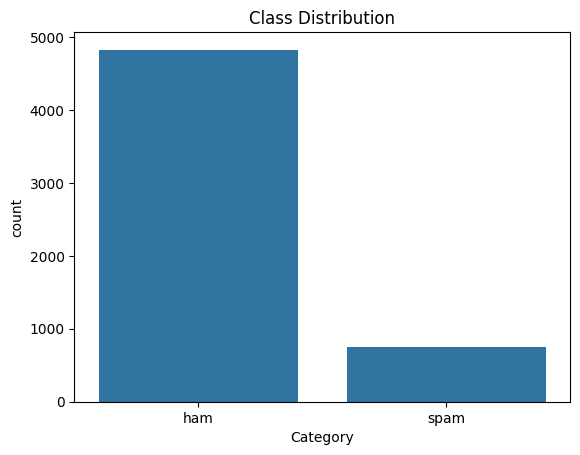

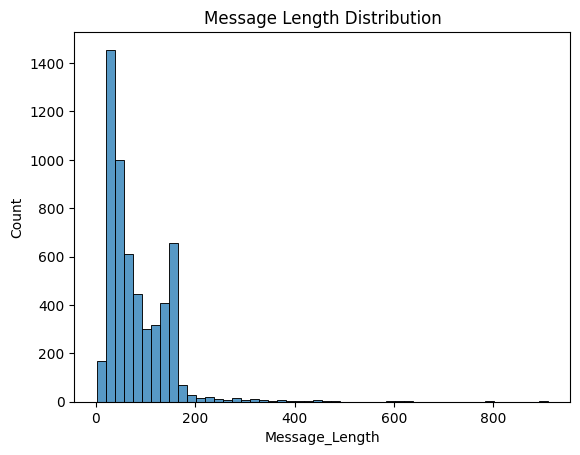

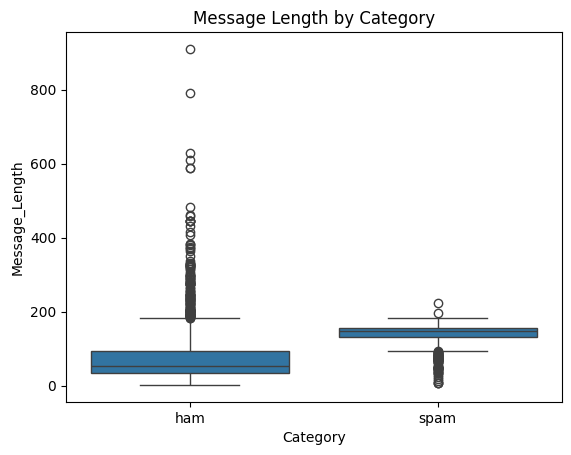

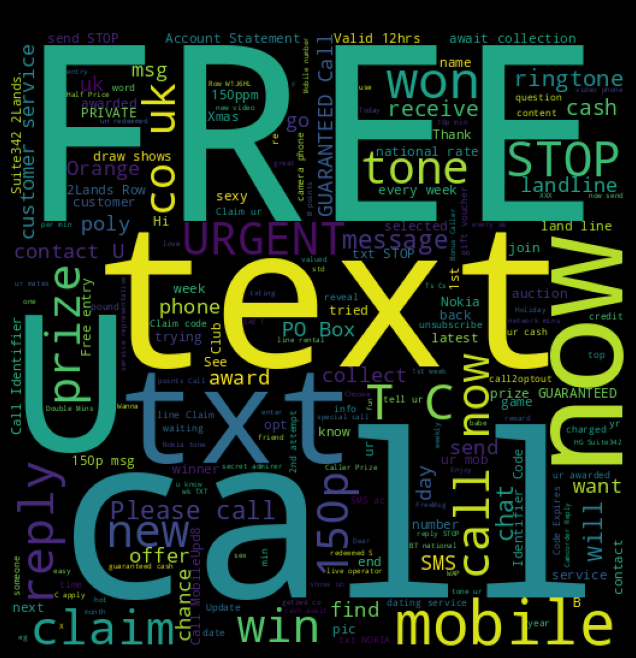

In [ ]:
sns.countplot(x='Category', data=df)
plt.title('Class Distribution')
plt.show()
sns.histplot(df['Message_Length'], bins=50)
plt.title('Message Length Distribution')
plt.show()
sns.boxplot(x='Category', y='Message_Length', data=df)
plt.title('Message Length by Category')
plt.show()
spam_words = ' '.join(list(df[df['Category'] == 'spam']['Message']))
spam_wc = WordCloud(width=512, height=512).generate(spam_words)
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.title('Spam Words')
plt.show()

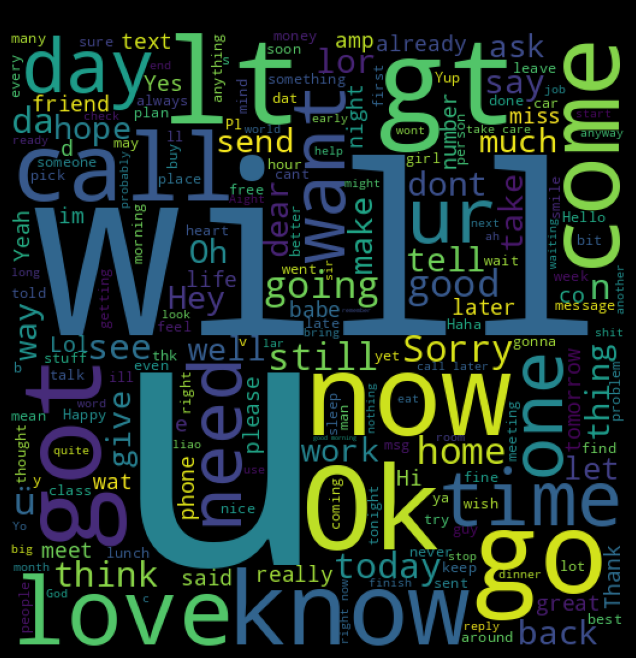

In [ ]:
ham_words = ' '.join(list(df[df['Category'] == 'ham']['Message']))
ham_wc = WordCloud(width=512, height=512).generate(ham_words)
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(ham_wc)
plt.axis('off')
plt.title('Ham Words')
plt.show()

In [ ]:
df.dropna(subset=["Message", "Category"], inplace=True)
df["Category"] = df["Category"].map({"ham": 0, "spam": 1})

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    processed_text = ' '.join(tokens)
    return processed_text

df['Message'] = df['Message'].apply(preprocess_text)
X = df["Message"]
y = df["Category"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)
k = 1000
selector = SelectKBest(chi2, k=k)
X_train_selected = selector.fit_transform(X_train_vectors, y_train)
X_test_selected = selector.transform(X_test_vectors)

In [ ]:
# Resampling Methods
smote = SMOTE(random_state=42)
X_train_resampled_smote, y_train_resampled_smote = smote.fit_resample(X_train_selected, y_train)

print("SMOTE Resampled shape:", X_train_resampled_smote.shape)
print("Random Over-sampling Resampled class distribution:", pd.Series(y_train_resampled_smote).value_counts())

# Random Over-sampling
ros = RandomOverSampler(random_state=42)
X_train_resampled_ros, y_train_resampled_ros = ros.fit_resample(X_train_selected, y_train)

print("Random Over-sampling Resampled shape:", X_train_resampled_ros.shape)
print("Random Over-sampling Resampled class distribution:", pd.Series(y_train_resampled_ros).value_counts())

# Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_resampled_rus, y_train_resampled_rus = rus.fit_resample(X_train_selected, y_train)

print("Random Under-sampling Resampled shape:", X_train_resampled_rus.shape)
print("Random Under-sampling Resampled class distribution:", pd.Series(y_train_resampled_rus).value_counts())

SMOTE Resampled shape: (7718, 1000)
Random Over-sampling Resampled class distribution: Category
1    3859
0    3859
Name: count, dtype: int64
Random Over-sampling Resampled shape: (7718, 1000)
Random Over-sampling Resampled class distribution: Category
1    3859
0    3859
Name: count, dtype: int64
Random Under-sampling Resampled shape: (1196, 1000)
Random Under-sampling Resampled class distribution: Category
0    598
1    598
Name: count, dtype: int64


In [ ]:
# Spot-Check Classification Algorithms
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}
print("\nSpot-Check Classification Algorithms:")
for name, model in models.items():
    model.fit(X_train_resampled_smote, y_train_resampled_smote)
    y_pred = model.predict(X_test_selected)
    print(f"{name} \n Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1-Score: {f1_score(y_test, y_pred)}")

print("\nSpot-Check Classification Algorithms with random oversampling:")
for name, model in models.items():
    model.fit(X_train_resampled_ros, y_train_resampled_ros)
    y_pred = model.predict(X_test_selected)
    print(f"\n{name} \n Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1-Score: {f1_score(y_test, y_pred)}")

print("\nSpot-Check Classification Algorithms with random undersampling:")
for name, model in models.items():
    model.fit(X_train_resampled_rus, y_train_resampled_rus)
    y_pred = model.predict(X_test_selected)
    print(f"{name} \n Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1-Score: {f1_score(y_test, y_pred)}")


Spot-Check Classification Algorithms:
Logistic Regression 
 Accuracy: 0.957847533632287
Precision: 0.7897727272727273
Recall: 0.9328859060402684
F1-Score: 0.8553846153846154
Naive Bayes 
 Accuracy: 0.9390134529147982
Precision: 0.7055837563451777
Recall: 0.9328859060402684
F1-Score: 0.8034682080924855
SVM 
 Accuracy: 0.9659192825112107
Precision: 0.8323353293413174
Recall: 0.9328859060402684
F1-Score: 0.879746835443038
Decision Tree 
 Accuracy: 0.9515695067264573
Precision: 0.841726618705036
Recall: 0.785234899328859
F1-Score: 0.8125
Random Forest 
 Accuracy: 0.9739910313901345
Precision: 0.96875
Recall: 0.8322147651006712
F1-Score: 0.8953068592057761

Spot-Check Classification Algorithms with random oversampling:

Logistic Regression 
 Accuracy: 0.9739910313901345
Precision: 0.8947368421052632
Recall: 0.912751677852349
F1-Score: 0.9036544850498339

Naive Bayes 
 Accuracy: 0.9372197309417041
Precision: 0.6926829268292682
Recall: 0.9530201342281879
F1-Score: 0.8022598870056498

SVM 
 A

In [ ]:
#cross-validation method
sampling_methods = {
    "SMOTE": (X_train_resampled_smote, y_train_resampled_smote),
    "Random Oversampling": (X_train_resampled_ros, y_train_resampled_ros),
    "Random Undersampling": (X_train_resampled_rus, y_train_resampled_rus)
}

for method, (X_resampled, y_resampled) in sampling_methods.items():
    print(f"\nModel Selection with {method}:")
    for name, model in models.items():
        accuracy = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()
        precision = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='precision').mean()
        recall = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='recall').mean()
        f1 = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='f1').mean()

        print(f"\n{name}:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")



Model Selection with SMOTE:

Logistic Regression:
  Accuracy:  0.9374
  Precision: 0.9633
  Recall:    0.9096
  F1-Score:  0.9356

Naive Bayes:
  Accuracy:  0.9044
  Precision: 0.8963
  Recall:    0.9230
  F1-Score:  0.9080

SVM:
  Accuracy:  0.9852
  Precision: 0.9718
  Recall:    0.9995
  F1-Score:  0.9854

Decision Tree:
  Accuracy:  0.9740
  Precision: 0.9744
  Recall:    0.9744
  F1-Score:  0.9745

Random Forest:
  Accuracy:  0.9935
  Precision: 0.9938
  Recall:    0.9922
  F1-Score:  0.9928

Model Selection with Random Oversampling:

Logistic Regression:
  Accuracy:  0.9675
  Precision: 0.9832
  Recall:    0.9513
  F1-Score:  0.9669

Naive Bayes:
  Accuracy:  0.9167
  Precision: 0.9043
  Recall:    0.9404
  F1-Score:  0.9205

SVM:
  Accuracy:  0.9885
  Precision: 0.9886
  Recall:    0.9883
  F1-Score:  0.9885

Decision Tree:
  Accuracy:  0.9845
  Precision: 0.9713
  Recall:    0.9995
  F1-Score:  0.9862

Random Forest:
  Accuracy:  0.9974
  Precision: 0.9969
  Recall:    1.0000


In [ ]:
model3 = RandomForestClassifier()
model3.fit(X_train_resampled_ros, y_train_resampled_ros)
y_pred = model3.predict(X_test_selected)

accuracy = cross_val_score(model3, X_train_resampled_ros, y_train_resampled_ros, cv=5, scoring='accuracy').mean()
precision = cross_val_score(model3, X_train_resampled_ros, y_train_resampled_ros, cv=5, scoring='precision').mean()
recall = cross_val_score(model3, X_train_resampled_ros, y_train_resampled_ros, cv=5, scoring='recall').mean()
f1 = cross_val_score(model3, X_train_resampled_ros, y_train_resampled_ros, cv=5, scoring='f1').mean()

#print(f"\n{name}:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

  Accuracy:  0.9977
  Precision: 0.9954
  Recall:    1.0000
  F1-Score:  0.9979


In [ ]:
#saving the best model
pickle.dump(model3, open('rf.pkl', 'wb'))
print("\nModel saved as rf.pkl")


Model saved as rf.pkl


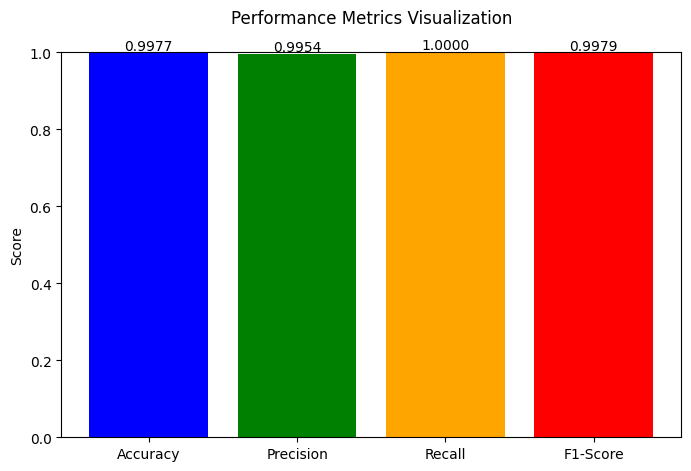

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, y_pred)

# Load the saved model
with open('rf.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1] 

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Performance Metrics Visualization\n')
plt.show()



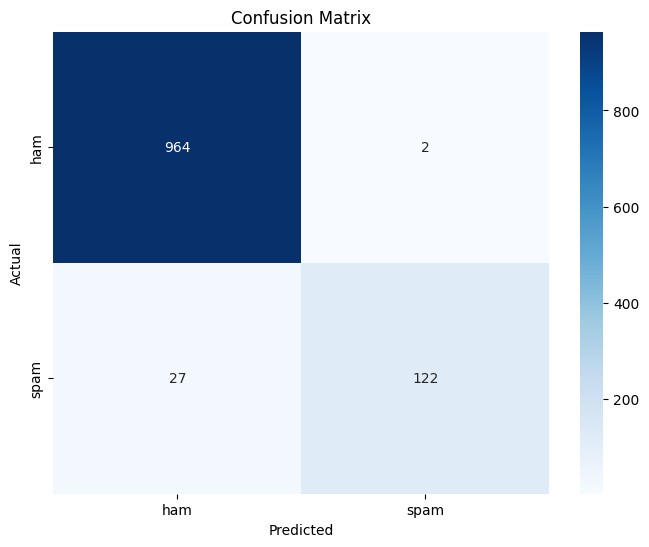

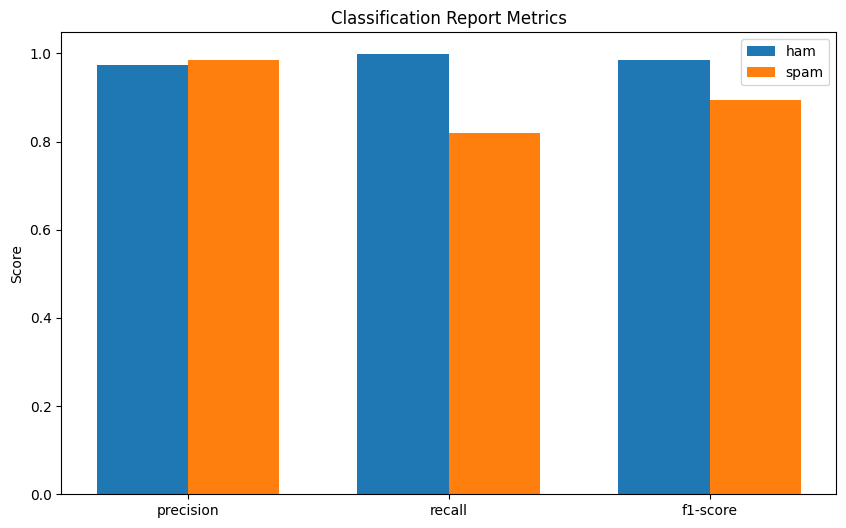

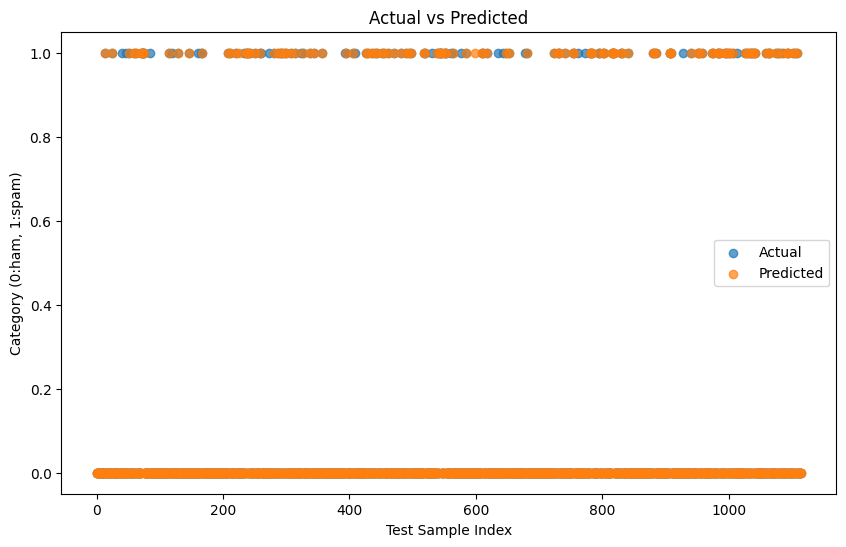

In [ ]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize Classification Report (Bar Chart)
report = classification_report(y_test, y_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
ham_values = [report['0'][metric] for metric in metrics]
spam_values = [report['1'][metric] for metric in metrics]

x = range(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, ham_values, width, label='ham')
plt.bar([i + width for i in x], spam_values, width, label='spam')

plt.xticks([i + width / 2 for i in x], metrics)
plt.ylabel('Score')
plt.title('Classification Report Metrics')
plt.legend()
plt.show()

#Visualize the predicted vs actual values.
plt.figure(figsize=(10,6))
plt.scatter(range(len(y_test)), y_test, label = "Actual", alpha = .7)
plt.scatter(range(len(y_pred)), y_pred, label = "Predicted", alpha = .7)
plt.legend()
plt.title("Actual vs Predicted")
plt.xlabel("Test Sample Index")
plt.ylabel("Category (0:ham, 1:spam)")
plt.show()

# Learning Outcome

Random Forest with Random Oversampling achieves the highest overall accuracy, precision, recall, and F1-score after cross-validation

*   Accuracy: 99.77%

*   Precision: 99.54%

*   Recall: 100.00%

*   F1-Score: 99.79%
